# Pretrained ALIGNN Models
Ashley S. Dale

Notebook loads a pretrained ALIGNN model, and calculates the loss landscape.

In [1]:
%matplotlib widget

In [2]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from alignn.pretrained import *
from jarvis.db.figshare import data

import ipywidgets as widgets
from torchinfo import summary

import loss_landscapes
import loss_landscapes.metrics

from abc import ABC, abstractmethod
from loss_landscapes.model_interface.model_wrapper import ModelWrapper
import torch

# Load Model

In [3]:
list_of_pretrained_models = list(get_all_models().keys())

-> Select the `jv_formation_energy_peratom_alignn` model for the demo

In [4]:
style = {'description_width': 'initial'}

config_selector = widgets.Dropdown(
    options=list_of_pretrained_models,
    value=None,
    description='Select Model',
    style=style,
    disabled=False,
)

display(config_selector)

Dropdown(description='Select Model', options=('jv_formation_energy_peratom_alignn', 'jv_optb88vdw_total_energy…

In [5]:
# This is the model we will load
model_name = config_selector.value
print("Selected: ", model_name)

Selected:  jv_formation_energy_peratom_alignn


In [6]:
model = get_figshare_model(model_name)

Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /Users/ashley/miniconda/envs/loss_landscapes_demo/lib/python3.10/site-packages/alignn/jv_formation_energy_peratom_alignn.zip
Config /Users/ashley/AUTODIAL/loss_landscapes_demo/jv_formation_energy_peratom_alignn/config.json


In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
ALIGNN                                   --
├─MLPLayer: 1-1                          --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  23,808
│    │    └─BatchNorm1d: 3-2             512
│    │    └─SiLU: 3-3                    --
├─Sequential: 1-2                        --
│    └─RBFExpansion: 2-2                 --
│    └─MLPLayer: 2-3                     --
│    │    └─Sequential: 3-4              5,312
│    └─MLPLayer: 2-4                     --
│    │    └─Sequential: 3-5              17,152
├─Sequential: 1-3                        --
│    └─RBFExpansion: 2-5                 --
│    └─MLPLayer: 2-6                     --
│    │    └─Sequential: 3-6              2,752
│    └─MLPLayer: 2-7                     --
│    │    └─Sequential: 3-7              17,152
├─ModuleList: 1-4                        --
│    └─ALIGNNConv: 2-8                   --
│    │    └─EdgeGatedGraphConv: 3-8      329,984
│  

We can use the model weights distribution to help scale the distance traveled on the loss landscape:

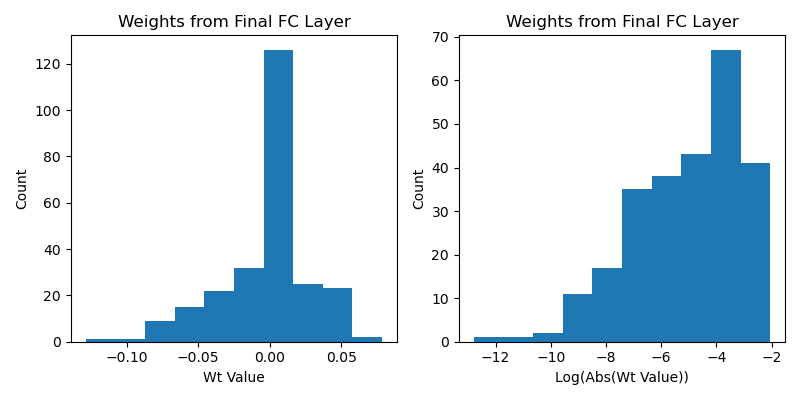

In [8]:
fc_layer_wts = model.fc.weight.detach().numpy()
counts, bins = np.histogram(fc_layer_wts)

log_counts, log_bins = np.histogram(np.log(np.abs(fc_layer_wts)))

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(bins[:-1], bins, weights=counts)
ax[0].set_title('Weights from Final FC Layer')
ax[0].set_xlabel('Wt Value')
ax[0].set_ylabel('Count')

ax[1].hist(log_bins[:-1], log_bins, weights=log_counts)
ax[1].set_title('Weights from Final FC Layer')
ax[1].set_xlabel('Log(Abs(Wt Value))')
ax[1].set_ylabel('Count')

fig.tight_layout()
plt.show()

In [9]:
print('avg wt val: ', np.mean(fc_layer_wts))
print('std wt val: ', np.std(fc_layer_wts))
wt_std = np.std(fc_layer_wts)

avg wt val:  -0.0033238737
std wt val:  0.030509515


# Load Data

In [10]:
## For larger sample
target="formation_energy_peratom"
n_samples = 250

d = data("dft_3d")
d = d[:n_samples]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


In [11]:
def get_data_loader(atoms_array, target):
    from torch.utils.data import DataLoader

    neighbor_strategy="k-nearest"
    atom_features="cgcnn"
    use_canonize=True
    line_graph=True
    batch_size = 1
    workers = 0
    pin_memory=False

    mem = []
    for i, ii in enumerate(atoms_array):
        info = {}
        info["atoms"] = ii['atoms']
        info["prop"] = ii[target]
        info["jid"] = str(i)
        mem.append(info)

    test_data = get_torch_dataset(
        dataset=mem,
        target="prop",
        neighbor_strategy=neighbor_strategy,
        atom_features=atom_features,
        use_canonize=use_canonize,
        line_graph=line_graph,
    )
    collate_fn = test_data.collate_line_graph

    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn,
        drop_last=False,
        num_workers=workers,
        pin_memory=pin_memory,
    )

    return test_loader

In [12]:
test_dataloader = get_data_loader(d, target)

data range 2.71694 -3.58436
Converting to graphs!


100%|██████████| 250/250 [00:03<00:00, 79.46it/s]


df                                                  atoms     prop  jid
0    {'lattice_mat': [[3.566933224304235, 0.0, -0.0... -0.42762    0
1    {'lattice_mat': [[4.089078911208881, 0.0, 0.0]... -0.41596    1
2    {'lattice_mat': [[-1.833590720595598, 1.833590...  0.04847    2
3    {'lattice_mat': [[7.2963518353359165, 0.0, 0.0... -0.44140    3
4    {'lattice_mat': [[1.6777483798834445, -2.90594... -0.71026    4
..                                                 ...      ...  ...
245  {'lattice_mat': [[3.083025257695259, -1.852747... -1.66792  245
246  {'lattice_mat': [[4.662788517797495, 0.0, -0.0... -0.30722  246
247  {'lattice_mat': [[3.1003051292413493, 1.053941... -0.24380  247
248  {'lattice_mat': [[-0.0, 5.005228456634498, 5.0...  0.94359  248
249  {'lattice_mat': [[5.0669622724129555, -0.0, 0.... -2.33628  249

[250 rows x 3 columns]
Setting it to max atomic number available here, 103
Setting it to max atomic number available here, 103
Setting it to max atomic number available

100%|██████████| 250/250 [00:00<00:00, 2120.98it/s]


In [13]:
single_batch = next(iter(test_dataloader))
len(single_batch)

3

In [14]:
print('Graph 1: ', single_batch[0])
print('Graph 2: ', single_batch[1])
print(target+': ', single_batch[2])

Graph 1:  Graph(num_nodes=8, num_edges=96,
      ndata_schemes={'V': Scheme(shape=(), dtype=torch.float32), 'coords': Scheme(shape=(3,), dtype=torch.float64), 'atomic_number': Scheme(shape=(1,), dtype=torch.float32), 'atom_features': Scheme(shape=(92,), dtype=torch.float32)}
      edata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)})
Graph 2:  Graph(num_nodes=96, num_edges=1152,
      ndata_schemes={'r': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'h': Scheme(shape=(), dtype=torch.float32)})
formation_energy_peratom:  tensor([-0.4276])


# Prepare Loss Landscape

In [15]:
model_final = copy.deepcopy(model)

In [28]:
STEPS=50
DISTANCE=10*wt_std

### Define Loss Function

In [29]:
criterion = torch.nn.L1Loss()

### Define Model Wrapper

In [30]:

class Metric(ABC):
    """ A quantity that can be computed given a model or an agent. """

    def __init__(self):
        super().__init__()

    @abstractmethod
    def __call__(self, model_wrapper: ModelWrapper):
        pass

class Loss(Metric):
    """ Computes a specified loss function over specified input-output pairs. """
    def __init__(self, loss_fn, model, inputs: torch.Tensor, target: torch.Tensor):
        super().__init__()
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.model = model
        self.target = target

    def __call__(self, model_wrapper: ModelWrapper) -> float:
        outputs = model_wrapper.forward(self.inputs)
        err = self.loss_fn(self.target, outputs)
        return err

## Calculate Loss Function

In [31]:
metric = Loss(criterion, model_final.eval(), (single_batch[0], single_batch[1]), single_batch[2])

In [32]:
loss_data_fin = loss_landscapes.random_plane(model_final, metric, distance=DISTANCE, steps=STEPS, normalization=None, deepcopy_model=True)

/Users/ashley/miniconda/envs/loss_landscapes_demo/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


# Plot the surface

In [ ]:
single_batch = next(iter(test_dataloader))
len(single_batch)

In [34]:
perturbation_range = np.round(np.linspace(-0.5*DISTANCE, 0.5*DISTANCE, 8), 3)

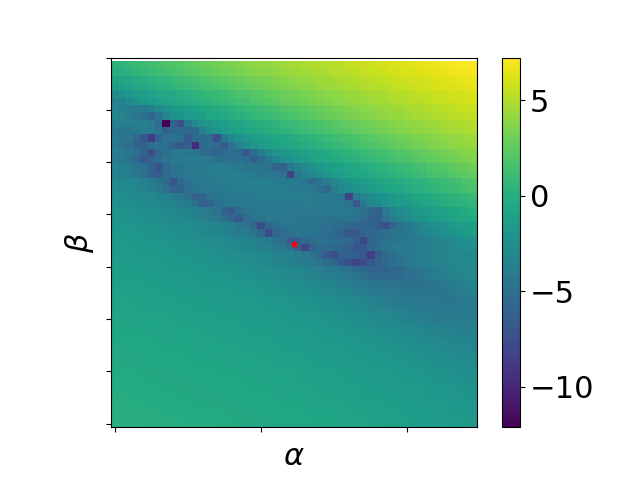

In [43]:
save_fig_name = os.path.join('loss_contours.png')
fig, ax = plt.subplots(1, 1)
plt.imshow(np.log(loss_data_fin), origin='lower')
# ax.set_title('Loss Contours \n'+ r'$L(\theta + \alpha i + \beta j$)')
ax.axis('square')
ax.scatter((STEPS-1)/2., (STEPS-1)/2., 20, 'r', '*')
# ax.set_xticks(np.linspace(0, STEPS, 8, endpoint=True))
# ax.set_xticklabels(perturbation_range)
ax.set_xticklabels(())
ax.set_yticks(np.linspace(0, STEPS, 8, endpoint=True))
# ax.set_yticklabels(perturbation_range)
ax.set_yticklabels(())
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.colorbar()
fig.savefig(save_fig_name, transparent=True, dpi=300)
plt.show()

In [23]:

plt.rcParams.update({'font.size': 22})

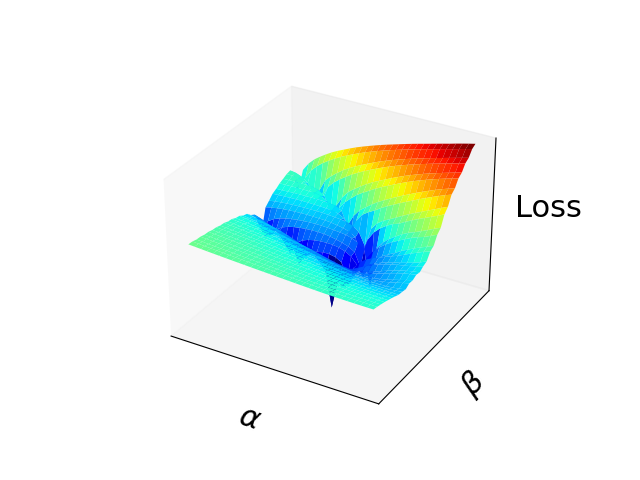

In [24]:
import numpy as np
save_fig_name = os.path.join('loss_surface.png')
fig = plt.figure()
ax = plt.axes(projection='3d')
X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
ax.plot_surface(X, Y, np.log(loss_data_fin), rstride=1, cstride=1, cmap='jet', edgecolor='none')
ax.set_xticks(np.linspace(0, STEPS, 8, endpoint=True))
ax.set_xticklabels(perturbation_range)
ax.set_yticks(np.linspace(0, STEPS, 8, endpoint=True))
ax.set_yticklabels(perturbation_range)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('Loss')
ax.grid('off')
ax.set_xticks(())
ax.set_yticks(())
ax.set_zticks(())
fig.savefig(save_fig_name, transparent=True, dpi=300, )
plt.show()